### 1.Importing the necessary libraries

In [293]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.preprocessing import sequence
from keras.models import Sequential,Model,load_model
from keras.layers import Embedding,Conv1D,MaxPooling1D
from keras.layers.core import Dense, Activation,Dropout ,Flatten
from keras.layers.recurrent import LSTM
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence,one_hot,Tokenizer
from keras.constraints import maxnorm

### 2. Initialize the seed inorder to get the same output every single time

In [131]:
seed = 120
np.random.seed(seed)

### 3. Loading the training data

In [132]:
train_path = './data/train/train_book_restaurant.csv'
train_df = pd.read_csv(train_path)# Loading a csv file with headers 
train_df.head()

,sentence_index,word,tag
0,0,book,O
1,0,The Middle East,restaurant_name
2,0,restaurant,restaurant_type
3,0,in,O
4,0,IN,state


### 4. Create a list of tuple to differentiate each sentence from each other sentence

In [252]:
class SentenceGetter(object):
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w,t) for w, t in zip(s["word"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_index").apply(agg_func)
        self.sentences = [s for s in self.grouped]
getter = SentenceGetter(train_df)
sentences = getter.sentences
# 1st sentence 
print(sentences[0:1])

[[('book ', 'O'), ('The Middle East', 'restaurant_name'), ('restaurant', 'restaurant_type'), (' in ', 'O'), ('IN', 'state'), (' for ', 'O'), ('noon', 'timeRange')]]


### 5. Maximum sentence sequence length

In [260]:
maxlen = max([len(s) for s in sentences])
print ('The maximum sentence sequence length:', maxlen)

The maximum sentence sequence length: 13


### 6. Checking how long the sentences:
1. maximum size of the sentence is <b>13</b>.
2. x-> axis denotes length of the sentence.
3. y-> The total sentences with x axis length.

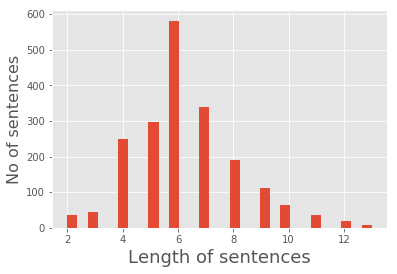

In [263]:
# Check how long sentences are so that we can pad them
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=30)

plt.xlabel('Length of sentences', fontsize=18)
plt.ylabel('No of sentences', fontsize=16)
plt.show()

### 7. Getting unique list of words and tags from train_df dataframe

In [399]:
# Getting unique list of words

# set() -> Removes duplicate elements
words = list(set(train_df["word"].values))
# Adding ENDPAD string at the end of word list
words.append("ENDPAD")

# Total no of words 
n_words = len(words)
print("Total no of words:",n_words)
print("Last word in word list:",words[n_words-1])

#  Getting unique list of tags
tags = list(set(train_df["tag"].values))
n_tags = len(tags)
print("Total no of tags:",n_tags)
print(tags)
if n_tags>maxlen:
    maxlen = n_tags

Total no of words: 3239
Last word in word list: ENDPAD
Total no of tags: 15
['state', 'country', 'sort', 'facility', 'party_size_description', 'restaurant_type', 'poi', 'served_dish', 'city', 'party_size_number', 'restaurant_name', 'spatial_relation', 'cuisine', 'timeRange', 'O']


### 8. Converting words and tags to a dictionary key:value pairs.
Here,
1. key -> Its the word or tag
2. value -> It is the index position of the word or the tag

In [400]:
# Creating a dictionary of words/tags and their respective index
# word to index
word2idx = {w: i for i, w in enumerate(words)}
# Tag to index
tag2idx =  {t: i for i, t in enumerate(tags)}
print("Word to index:",word2idx)

Word to index: {'Conshohocken': 0, 'make me a reservation at ': 1, 'my great grandfather and I': 2, 'book any ': 3, 'West Richfield': 4, 'me, emily and gena': 5, 'jul. 4th': 6, 'Macao': 7, ' reserved.': 8, ' want to go to a ': 9, 'spanish': 10, 'Piper': 11, 'Belle Plaine': 12, 'ebony and yolanda': 13, 'Friday': 14, ' with the ': 15, 'Durant': 16, 'crepes': 17, 'Brusly Landing': 18, 'march the twenty-seventh': 19, 'Rockaway Park-Beach 116th': 20, 'eleven am': 21, ' away at ': 22, 'apple sauce': 23, ' and book seats for ': 24, 'book me ': 25, 'Blodgett': 26, ' at a  ': 27, 'wilda and jacklyn': 28, 'Find a reservation ': 29, 'I need a table at ': 30, 'Bangladesh': 31, 'Hungary': 32, ' late at ': 33, 'fish and chips': 34, ' would like to go to a ': 35, 'Can you get me seating at a ': 36, 'CO': 37, 'five': 38, ' located at ': 39, 'Lucerne Valley': 40, 'I want to make a reservation at the ': 41, 'me and my colleagues': 42, 'Get me a ': 43, 'Rustic inn': 44, 'June nineteenth': 45, 'near': 46,

In [401]:
print("Tag to index:",tag2idx)

Tag to index: {'state': 0, 'country': 1, 'sort': 2, 'facility': 3, 'party_size_description': 4, 'restaurant_type': 5, 'poi': 6, 'served_dish': 7, 'city': 8, 'party_size_number': 9, 'restaurant_name': 10, 'spatial_relation': 11, 'cuisine': 12, 'timeRange': 13, 'O': 14}


### 9. Padding the sentence sequence to the maximum sentence sequence length 13

In [402]:
# 1. Padding word sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
print("Before Padding:",X[0])

# maxlen = 13 (for padding)
# sequence -> contains X list
# post -> padding should be done after the sentence sequence
# value -> n_words = 3239
# value = 3239 - 1 = 3238 
# Here the value that is padded is 3238 which is the index of the loast word in the list [ENDPAD]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)
print("After  Padding:",X[0])
print("Word used for padding:",words[n_words-1]) # ENDPAD -> used as a filler in padding

Before Padding: [2754, 787, 3206, 1489, 503, 2682, 2544]
After  Padding: [2754  787 3206 1489  503 2682 2544 3238 3238 3238 3238 3238 3238 3238
 3238]
Word used for padding: ENDPAD


In [403]:
# 2. Padding Tag sequence
y = [[tag2idx[w[1]] for w in s] for s in sentences]
print("Before padding:",y[0])
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
print("After padding:",y[0])
print("Categorical Data:")
y = [to_categorical(i, num_classes=n_tags) for i in y]
print(y[0])
print("Shape of categorical data:",y[0].shape)

Before padding: [14, 10, 5, 14, 0, 14, 13]
After padding: [14 10  5 14  0 14 13 14 14 14 14 14 14 14 14]
Categorical Data:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Shape of categorical data: (15, 15)


### 10. Splitting the training and testing sample in a partition of 80/20
- 80% training sample
- 20% testing sample

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [393]:
print(n_words)

3239


### 11. Neural Network Model

In [394]:
#model
model = Sequential()

model.add(Embedding(input_dim=n_words, output_dim=15, input_length=15)) #to change words to ints

model.add(Dropout(0.1))
model.add(Dense(1200, activation='relu',W_constraint=maxnorm(1)))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))
#output layer
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))
model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1200, activation="relu", kernel_constraint=<keras.con...)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 15, 15)            48585     
_________________________________________________________________
dropout_18 (Dropout)         (None, 15, 15)            0         
_________________________________________________________________
dense_31 (Dense)             (None, 15, 1200)          19200     
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 15, 200)           1040800   
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 15)            3015      
Total params: 1,111,600
Trainable params: 1,111,600
Non-trainable params: 0
_________________________________________________________________


In [212]:
# input = Input(shape=(13,))
# model = Embedding(input_dim=n_words, output_dim=13, input_length=13)(input)
# model = Dropout(0.1)(model)
# model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
# out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
# model = Model(input, out)
# model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [395]:
# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
# Train the model
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=35, validation_split=0.2, verbose=1)

Train on 1262 samples, validate on 316 samples
Epoch 1/35
1262/1262 [==============================] - 16s 12ms/step - loss: 1.3269 - acc: 0.7623 - val_loss: 0.9086 - val_acc: 0.7838
Epoch 2/35
1262/1262 [==============================] - 8s 6ms/step - loss: 0.8456 - acc: 0.7828 - val_loss: 0.7641 - val_acc: 0.7873
Epoch 3/35
1262/1262 [==============================] - 8s 6ms/step - loss: 0.6155 - acc: 0.8247 - val_loss: 0.4867 - val_acc: 0.8517
Epoch 4/35
1262/1262 [==============================] - 8s 6ms/step - loss: 0.3741 - acc: 0.8819 - val_loss: 0.3130 - val_acc: 0.9078
Epoch 5/35
1262/1262 [==============================] - 8s 6ms/step - loss: 0.2392 - acc: 0.9282 - val_loss: 0.2363 - val_acc: 0.9276
Epoch 6/35
1262/1262 [==============================] - 8s 6ms/step - loss: 0.1609 - acc: 0.9516 - val_loss: 0.2040 - val_acc: 0.9376
Epoch 7/35
1262/1262 [==============================] - 8s 6ms/step - loss: 0.1101 - acc: 0.9706 - val_loss: 0.1972 - val_acc: 0.9424
Epoch 8/35
12

### 12. Calculating the score

In [407]:
print("=============================== Score =========================================")
# Finally calucating the score.
score = model.evaluate(np.array(X_test), np.array(y_test), verbose=1)
print('Test accuracy:', score[1],'%')


=============================== Score =========================================
395/395 [==============================] - 1s 2ms/step
Test accuracy: 0.9414345929894267 %


### 13. Predicting the test scamples

In [482]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
#print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(words[w],tags[pred]))

I really need a : timeRange
top-rated      : sort
restaurant     : restaurant_type
 that can seat : O
3              : party_size_number
 people        : O
in 1 minute    : timeRange
 from now.     : timeRange
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O


### 14. Predicting my text 

In [480]:
sequences =[]
sentence = "Book a restaurant with parking facility for 3"
for word in sentence.split(" "):
    try:
        sequences.append(word2idx[word])
    except:
        sequences.append(word2idx['ENDPAD'])    
print(sequences)        
padded_sequence = pad_sequences(maxlen=maxlen, sequences=[sequences], padding="post",value=n_words - 1)
p = model.predict([padded_sequence])
p = np.argmax(p, axis=-1)
tag_list = []
for i in p:
    for j in i:
        tag_list.append(j)
print(tag_list)
for i in p:
    count = 0
    for j in sentence.split():
        print("Word:",j,"             ","Tag:",tags[tag_list[count]])
        count = count + 1

[3238, 3238, 3206, 3238, 426, 3238, 3238, 271]
[14, 14, 5, 14, 3, 14, 14, 9, 14, 14, 14, 14, 14, 14, 14]
Word: Book               Tag: O
Word: a               Tag: O
Word: restaurant               Tag: restaurant_type
Word: with               Tag: O
Word: parking               Tag: facility
Word: facility               Tag: O
Word: for               Tag: O
Word: 3               Tag: party_size_number


### 15.Saving your model to json and weights as HDF5 format

In [484]:
# serialize model to JSON
model_json = model.to_json()
with open("./data/model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("./data/model.h5")
print("Saved model to disk")

Saved model to disk
